In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import esmtools as et
from esmtools import stats

import shapefile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gp
import regionmask
import matplotlib.patches as mpatches
import xesmf as xe

In [2]:
# Open dataset of potential temperature
dr = '/home/jovyan/SOARS_2021/Data/CESM2/'
fn = 'thetao_Omon_CESM2_omip2_r1i1p1f1_gr_030601-036612.nc'

data_thetao = xr.open_dataset(dr+fn)

/home/jovyan/my-conda-envs/analysis/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'thetao' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [3]:
# Change the time to be from DatetimeNoLeap to a Datetime64
data_thetao['time'] = np.arange('1958-01-01','2019-01-01',dtype = 'datetime64[M]')
data_thetao

<xarray.Dataset>
Dimensions:    (d2: 2, lat: 180, lev: 33, lon: 360, time: 732)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2018-12-01
  * lev        (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: d2
Data variables:
    time_bnds  (time, d2) object ...
    lev_bnds   (lev, d2) float64 ...
    lat_bnds   (lat, d2) float64 ...
    lon_bnds   (lon, d2) float64 ...
    thetao     (time, lev, lat, lon) float32 ...
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            OMIP
    branch_method:          no parent
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    case_id:                1540
    ...                     ...
    tracking_id:            hdl:21.14100/d1215989-317f-485b-b009-4da10514318b
    variable_id:            thetao
    variant_info:           CMIP6 omip2 experiment (JRA forcing) with interac...
    variant_label:          r1i1p1f1
    source_type:            OGCM BGC
    comment:                Experiment run for 6 cycles of 1958-2018 JRA55 fo...

In [4]:
thetao = data_thetao['thetao']

In [5]:
#depth = thetao.sel(lev=slice(0,500)) # * 0.01 only apply if depth is in centimeters 
thetao['time'] = pd.date_range("1958-01", "2018-12", freq="MS")
thetao = thetao.sel(time=slice('1985-01','2017-01'))

In [6]:
# slice the region you want
thetao = thetao.sel(lon=slice(200,215),lat=slice(40,50), lev=slice(0,500)) #.mean(dim=('lat','lon'))

In [7]:
# weight the values!
weights = np.cos(np.deg2rad(thetao.lat))
weights.name = "weights"
thetao = thetao.weighted(weights).mean(dim=('lat','lon'))

In [13]:
# remove long-term trends
thetao = stats.rm_poly(thetao,order=2,dim='time')

In [16]:
# set the time periods
non_blob = thetao.sel(time=slice('1985-01','2010-12')) #.groupby('time.month').mean()
non_blob_std = thetao.sel(time=slice('1985-01','2010-12')).std() #.groupby('time.month').std()# / np.sqrt(25)
blob = thetao.sel(time=slice('2013-07','2016-06')) #.groupby('time.month').mean()
blob

<xarray.DataArray (lev: 14, time: 36)>
array([[ 3.11213993e+00,  4.68744540e+00,  4.11789893e+00,
         2.80941992e+00,  1.52572334e+00,  5.53425751e-01,
        -5.00810049e-01, -1.51880452e+00, -2.09121883e+00,
        -2.14336263e+00, -9.73877302e-01,  1.00531240e+00,
         2.68299445e+00,  4.42218687e+00,  5.20801163e+00,
         2.68254266e+00,  1.49762347e-01, -1.29645391e+00,
        -2.01800607e+00, -2.40998217e+00, -2.45464203e+00,
        -2.57276672e+00, -1.50690112e+00,  5.63588391e-01,
         2.69432396e+00,  5.27590455e+00,  5.34535264e+00,
         3.01856417e+00,  9.22232582e-01, -1.09920052e+00,
        -2.45125005e+00, -3.26978124e+00, -3.71711070e+00,
        -3.62137387e+00, -2.63177636e+00, -4.21869975e-01],
       [ 3.03235207e+00,  4.68629865e+00,  4.12964182e+00,
         2.82943004e+00,  1.54880771e+00,  5.76479346e-01,
        -4.76617936e-01, -1.49557030e+00, -2.07052019e+00,
        -2.12606495e+00, -1.01883749e+00,  9.85020164e-01,
         2.63295156e+00,  4.40322462e+00,  5.20797533e+00,
         2.70411148e+00,  1.73535834e-01, -1.27222413e+00,
        -1.99427442e+00, -2.38878092e+00, -2.43336860e+00,
        -2.55729683e+00, -1.53741654e+00,  5.31609602e-01,
...
        -7.19755380e-02, -5.90939120e-02, -4.24759587e-02,
        -3.66284507e-02, -3.94258767e-02, -6.15172812e-02,
        -9.48177506e-02, -1.27978760e-01, -1.38426826e-01,
        -1.29341942e-01, -1.10732779e-01, -9.47602856e-02,
        -7.53541066e-02, -4.06701195e-02, -6.83543889e-03,
        -5.02797977e-03,  1.03246884e-02,  2.94956150e-03,
        -2.24791267e-02, -6.06060247e-02, -1.09217006e-01,
        -1.12213175e-01, -9.12600028e-02, -7.06852153e-02],
       [-1.68342260e-02, -1.69583657e-02, -1.65568310e-02,
        -1.38753867e-02, -1.38522448e-02, -1.81106420e-02,
        -2.40145079e-02, -3.87139452e-02, -5.38546574e-02,
        -5.66601888e-02, -5.98170614e-02, -5.51882001e-02,
        -5.15577016e-02, -4.46465192e-02, -3.52084849e-02,
        -3.26201824e-02, -3.50625220e-02, -5.06016770e-02,
        -7.11323181e-02, -9.11530285e-02, -9.84460764e-02,
        -9.39014734e-02, -8.30681980e-02, -7.28361089e-02,
        -6.07330712e-02, -3.88592796e-02, -1.73983158e-02,
        -1.66289891e-02, -6.26008567e-03, -9.79510627e-03,
        -2.48725258e-02, -4.75123791e-02, -7.72921588e-02,
        -7.90229108e-02, -6.51294710e-02, -5.06886139e-02]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01 2013-08-01 ... 2016-06-01
  * lev      (lev) float64 0.0 10.0 20.0 30.0 50.0 ... 250.0 300.0 400.0 500.0

In [19]:
# Resample to two month resolution
blob = blob.resample(time='2M').mean()
non_blob = non_blob.resample(time='2M').mean()
blob

<xarray.DataArray (lev: 14, time: 19)>
array([[ 3.11213993e+00,  4.40267216e+00,  2.16757163e+00,
         2.63078510e-02, -1.80501167e+00, -1.55861996e+00,
         1.84415343e+00,  4.81509925e+00,  1.41615250e+00,
        -1.65722999e+00, -2.43231210e+00, -2.03983392e+00,
         1.62895618e+00,  5.31062860e+00,  1.97039838e+00,
        -1.77522528e+00, -3.49344597e+00, -3.12657511e+00,
        -4.21869975e-01],
       [ 3.03235207e+00,  4.40797023e+00,  2.18911888e+00,
         4.99307053e-02, -1.78304525e+00, -1.57245122e+00,
         1.80898586e+00,  4.80559998e+00,  1.43882366e+00,
        -1.63324927e+00, -2.41107476e+00, -2.04735668e+00,
         1.59102717e+00,  5.29564903e+00,  1.99270513e+00,
        -1.75083534e+00, -3.47047360e+00, -3.13026017e+00,
        -4.76361204e-01],
       [ 2.58570670e+00,  4.40569189e+00,  2.31370293e+00,
         1.78792597e-01, -1.65692173e+00, -1.57530477e+00,
         1.64699810e+00,  4.68842239e+00,  1.56755889e+00,
        -1.50145673e+00, -2.28500117e+00, -2.01324718e+00,
         1.37533389e+00,  5.07987520e+00,  2.12272153e+00,
        -1.61649445e+00, -3.33827712e+00, -3.08108041e+00,
...
        -1.12848581e-02, -6.31528754e-02, -8.14761184e-02,
        -6.16232620e-02, -2.14684435e-02, -1.43348070e-03,
        -5.66153858e-02, -1.41058918e-01, -1.23256675e-01,
        -7.69325748e-02,  2.39375351e-03,  3.60659840e-02,
         8.15243496e-03, -1.08797988e-01, -1.43824672e-01,
        -1.07948822e-01],
       [-3.65157077e-02, -3.38145159e-02, -2.37488692e-02,
        -3.13546554e-02, -6.96070645e-02, -8.59757384e-02,
        -7.57430529e-02, -5.07849353e-02, -3.80271637e-02,
        -7.81675159e-02, -1.33202793e-01, -1.20037361e-01,
        -8.50571961e-02, -2.37527792e-02,  2.64835432e-03,
        -9.76478261e-03, -8.49115152e-02, -1.01736589e-01,
        -7.06852153e-02],
       [-1.68342260e-02, -1.67575984e-02, -1.38638158e-02,
        -2.10625750e-02, -4.62843013e-02, -5.82386251e-02,
        -5.33729509e-02, -3.99275021e-02, -3.38413522e-02,
        -6.08669976e-02, -9.47995524e-02, -8.84848357e-02,
        -6.67845901e-02, -2.81287977e-02, -1.14445374e-02,
        -1.73338161e-02, -6.24022690e-02, -7.20761909e-02,
        -5.06886139e-02]])
Coordinates:
  * time     (time) datetime64[ns] 2013-07-31 2013-09-30 ... 2016-07-31
  * lev      (lev) float64 0.0 10.0 20.0 30.0 50.0 ... 250.0 300.0 400.0 500.0

ValueError: x and y must have same first dimension, but have shapes (1,) and (14,)

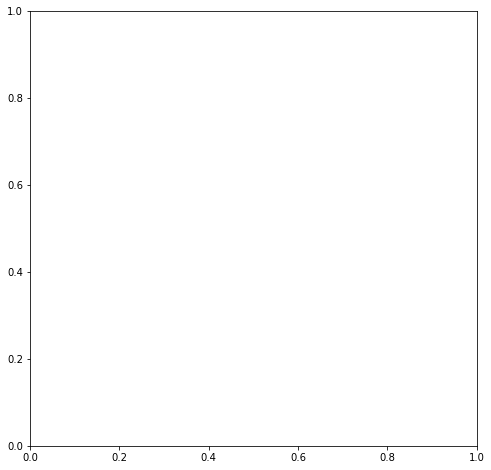

In [27]:
# plot that data...
f, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(blob.sel(time='2014-01-31').mean(),blob.lev,color='k',label='Jan-Feb, 2014')
#ax.plot(non_blob.isel(month=slice(0,2)).mean(dim='month'),non_blob.lev,color='green',label='Jan-Feb,1985-2010')
#ax.fill_betweenx(blob.lev,
#                 non_blob.isel(month=slice(0,2)).mean(dim='month')+non_blob_std.isel(month=slice(0,2)).mean(dim='month'),
#                 non_blob.isel(month=slice(0,2)).mean(dim='month')-non_blob_std.isel(month=slice(0,2)).mean(dim='month'), 
#                 color='black',
#                 alpha=0.2)
ax.invert_yaxis()
ax.set_title('Potential Temperature Anomaly ($^{o}$ C) CESM2', fontsize=13, pad=10)
ax.set_xlim(-3.6,3.6)
ax.legend(fontsize=20,loc='lower left')

In [ ]:
def panels(data,description,variable,depth,lower_bound,upper_bound, step):
    f, axs = plt.subplots(nrows=3,ncols=6,figsize=(20,6)) 
    for i in range(0,18):
        im = ax[i].plot(blob.isel(month=i).mean(dim='month'),blob.lev,color='k')
        ax[i].plot(non_blob.isel(month=i).mean(dim='month'),blob.lev,color='green',label='Jan-Feb,1985-2010')
        ax[i].fill_betweenx(blob.lev,
                 non_blob.isel(month=i).mean(dim='month')+non_blob_std.isel(month=slice(0,2)).mean(dim='month'),
                 non_blob.isel(month=i).mean(dim='month')-non_blob_std.isel(month=slice(0,2)).mean(dim='month'), 
                 color='black',
                 alpha=0.2)
        ax[i].invert_yaxis()
        ax[i].set_title('Potential Temperature Anomaly ($^{o}$ C) CESM2', fontsize=13, pad=10)
        ax[i].set_xlim(-3.6,3.6)
    
    plt.suptitle("CESM2: " + description + " " + variable + " " + depth + " (de-trended)")
    axs[0].set_title("Jul-Aug"); axs[1].set_title("Sept-Oct")
    axs[2].set_title("Nov-Dec"); axs[3].set_title("Jan-Feb")
    axs[4].set_title("Mar-Apr"); axs[5].set_title("May-Jun")
    plt.text(-790,215,'2013-14')
    plt.text(-790,120,'2014-15')
    plt.text(-790,25,'2015-16')
    f.subplots_adjust(right=0.8)
    
panels('SSTA','NE','Pacific',-4.0,4.0, 1.0,'RdBu_r')